# XG Boost Model

This is the primary model used for our project. We are using an XG Boost model to learn traffic parameters at intersections. More details are listed

In [16]:
# required imports
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib

This geocoding is used to import our model and outputs of the model into google maps. This is currently not automated because we do not have the proper server power, but we can automate this script on a web server if we can ever attain a powerful one.

In [19]:
import geopy

coordinateList = []
addressList = []

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="traffixai") # link the website agent

for x in range(len(coordinateList)):
    location = geolocator.reverse("52.509669, 13.376294")
    addressList.append(location)


### Data Loading
We will begin by loading the extracted features and cleaned dataset from the last notebook.

In [3]:
# plt perferences
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
pd.set_option('display.max_columns', 99)

In [30]:
# load data
full = pd.read_csv('./data/features_v3.csv.gz')
full.head()

,City,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,EntryHeading,EntryStreetName,ExitHeading,ExitStreetName,Hour,IntersectionId,Istrain,Latitude,Longitude,Month,Path,RowId,TimeFromFirstStop_p20,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,TotalTimeStopped_p20,TotalTimeStopped_p40,TotalTimeStopped_p50,TotalTimeStopped_p60,TotalTimeStopped_p80,Weekend,ValidationGroup,Latitude3,Longitude3,EntryStreetMissing,ExitStreetMissing,CMWH,DiffHeading,Rainfall,Temperature,EntryType,ExitType,Intersection,SameStreet,LatitudeDist,LongitudeDist,CenterDistL1,CenterDistL2,Longitude3Count,Latitude3Count,ExitStreetNameCount,EntryStreetNameCount,IntersectionCount,Longitude3UniqueIntersections,Latitude3UniqueIntersections,ExitStreetNameUniqueIntersections
0,0,0.0,0.0,0.0,0.0,0.0,1.75,212,1.75,209,0,0,1,-2.007996,-1.096389,6,Marietta Boulevard Northwest_NW_Marietta Boule...,1921357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,33.792,-84.43,0,0,167,0.0,3.63,76,4,4,0,1,0.026,0.032,0.29,0.124,1560,8260,7890,7750,650,2,10,9
1,0,0.0,0.0,0.0,0.0,0.0,0.75,212,0.75,209,0,0,1,-2.007996,-1.096389,6,Marietta Boulevard Northwest_SE_Marietta Boule...,1921358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,33.792,-84.43,0,0,167,0.0,3.63,76,4,4,0,1,0.026,0.032,0.29,0.124,1560,8260,7890,7750,650,2,10,9
2,0,0.0,0.0,0.0,0.0,0.0,1.75,212,1.75,209,1,0,1,-2.007996,-1.096389,6,Marietta Boulevard Northwest_NW_Marietta Boule...,1921359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,33.792,-84.43,0,0,168,0.0,3.63,76,4,4,0,1,0.026,0.032,0.29,0.124,1560,8260,7890,7750,650,2,10,9
3,0,0.0,0.0,0.0,0.0,0.0,0.75,212,0.75,209,1,0,1,-2.007996,-1.096389,6,Marietta Boulevard Northwest_SE_Marietta Boule...,1921360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,33.792,-84.43,0,0,168,0.0,3.63,76,4,4,0,1,0.026,0.032,0.29,0.124,1560,8260,7890,7750,650,2,10,9
4,0,0.0,0.0,0.0,0.0,0.0,1.75,212,1.75,209,2,0,1,-2.007996,-1.096389,6,Marietta Boulevard Northwest_NW_Marietta Boule...,1921361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,33.792,-84.43,0,0,179,0.0,3.63,76,4,4,0,1,0.026,0.032,0.29,0.124,1560,8260,7890,7750,650,2,10,9


In [31]:
# We will use a training size of 75%.
TRAIN_SAMPLE_SIZE = 0.75

We will use just a few specific columns. We will use the time stopped at each intersection as well as distance to first stop, as these will allow the model to learn the most amount of information. We will not use the unneccesary columns. The time stopped parameter can allow us to predict time stopped at each intersection, and therefore, when we mkae changes in the parameters of the data, we can predict wait times at intersections after changes. This metric can be converted into multiple others through calculations.

In [32]:
full['random'] = np.random.rand(len(full))

# separate train and test sets
train = full[full.Istrain == 1]
test = full[full.Istrain == 0]

# column stats
column_stats = pd.concat([
    pd.DataFrame(full.count()).rename(columns={0: 'cnt'}),
    pd.DataFrame(full.nunique()).rename(columns={0: 'unique'}),
], sort=True, axis=1)
column_stats.sort_values(by='unique')

train_columns = list(column_stats[column_stats.cnt < 10 ** 6].index)

# features to use
target_columns = [
    'TotalTimeStopped_p20',
    'TotalTimeStopped_p50',
    'TotalTimeStopped_p80',
    'DistanceToFirstStop_p20',
    'DistanceToFirstStop_p50',
    'DistanceToFirstStop_p80',
]

# features not to use
do_not_use = train_columns + ['IsTrain', 'Path', 'RowId', 'IntersectionId',
                              'random', 'intersection_random', 'ValidationGroup']

# set feature columns
feature_columns = [c for c in full.columns if c not in do_not_use]

# Model Building and Training
Now we will build our model. We will begin by setting some basic hyperparameters for our model such as the booster and the loss objective.

In [13]:
# set "fix" which are the prefered parameters
fix = {
    'lambda': 1., 'nthread': 4, 'booster': 'gbtree',
    'silent': 1, 'eval_metric': 'rmse',
    'objective': 'reg:squarederror'}
config = dict(min_child_weight=20,
              eta=0.05, colsample_bytree=0.6,
              max_depth=20, subsample=0.8)
config.update(fix)
nround = 200

## Training
Now we will train our model on the chosen parameters one at a time. The model is an XG Boost with parameters set in the previous cell. We will train for 50 rounds.

In [15]:
# intantiate initial loss and targets

total_mse = 0.0
targets = []
for i, target in enumerate(target_columns): # loop through the chosen features to train on
    print(f'Training and predicting for target {target}')
    train_idx = train.random < TRAIN_SAMPLE_SIZE
    valid_idx = train.random >= TRAIN_SAMPLE_SIZE

    # split train/test and labels
    Xtr = train[train_idx][feature_columns]
    Xv = train[valid_idx][feature_columns]
    ytr = train[train_idx][target].values
    yv = train[valid_idx][target].values
    print(Xtr.shape, ytr.shape, Xv.shape, yv.shape)
    
    # reshare for boost model
    dtrain = xgb.DMatrix(Xtr, label=ytr)
    dvalid = xgb.DMatrix(Xv, label=yv)

    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    # initialize model
    model = xgb.train(config, dtrain, nround, evals=watchlist,
                      verbose_eval=50, early_stopping_rounds=50)

    pv = model.predict(dvalid) # Predict on data
    mse = np.mean((yv - pv) ** 2) #  MSE Loss 
    total_mse += mse / 6
    print(target, 'rmse', np.sqrt(mse))
    
    # add metrics to dataframe
    df = pd.DataFrame({
        'TargetId': test.RowId.astype(str) + '_' + str(i),
        'Target': model.predict(xgb.DMatrix(test[feature_columns]))})
    targets.append(df)

Training and predicting for target TotalTimeStopped_p20
(642215, 35) (642215,) (214172, 35) (214172,)
[12:37:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:7.11108	valid-rmse:7.20991
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:4.98814	valid-rmse:5.72920
[100]	train-rmse:4.48359	valid-rmse:5.60887
[150]	train-rmse:4.25747	valid-rmse:5.58935
[199]	train-rmse:4.10029	valid-rmse:5.58856
TotalTimeStopped_p20 rmse 5.588741167296197
Training and predicting for target TotalTimeStopped_p50
(642215, 35) (642215,) (214172, 35) (214172,)
[12:45:56] WARNING: /Users/travis/

In [17]:
#save model
joblib.dump(model, "./models/xgboost.h5") 

['./models/xgboost.h5']

## Testing
Now that we have a trained model, we will test our model on the validation set to find its performance.

One problem that we notice is that the model is overfitting to the training data. There is a large change in performance when evaluating on the test set. There is also a large difference in local validation.

We will first plot the spatial distribution of our train/test sets. This will allow us to see where the majority of intersections are in the respective cities and how heavy and dense the traffic is. Since this is latitude/longitude based, we can export this to Google Maps on the main site.

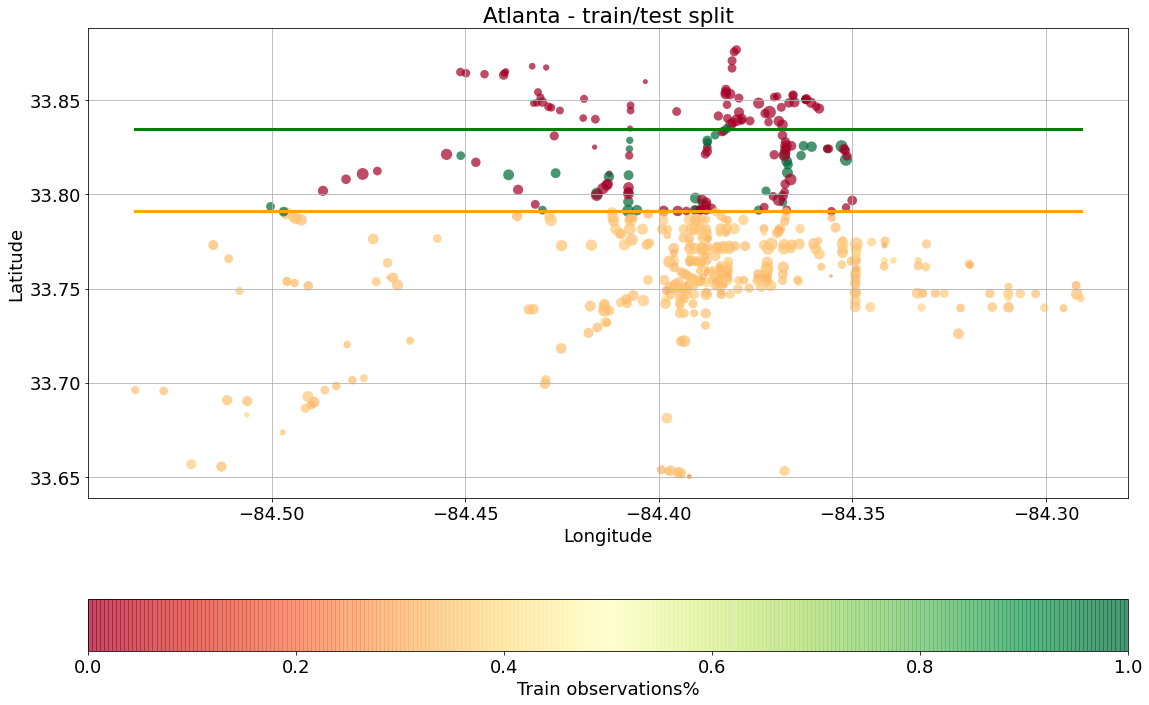

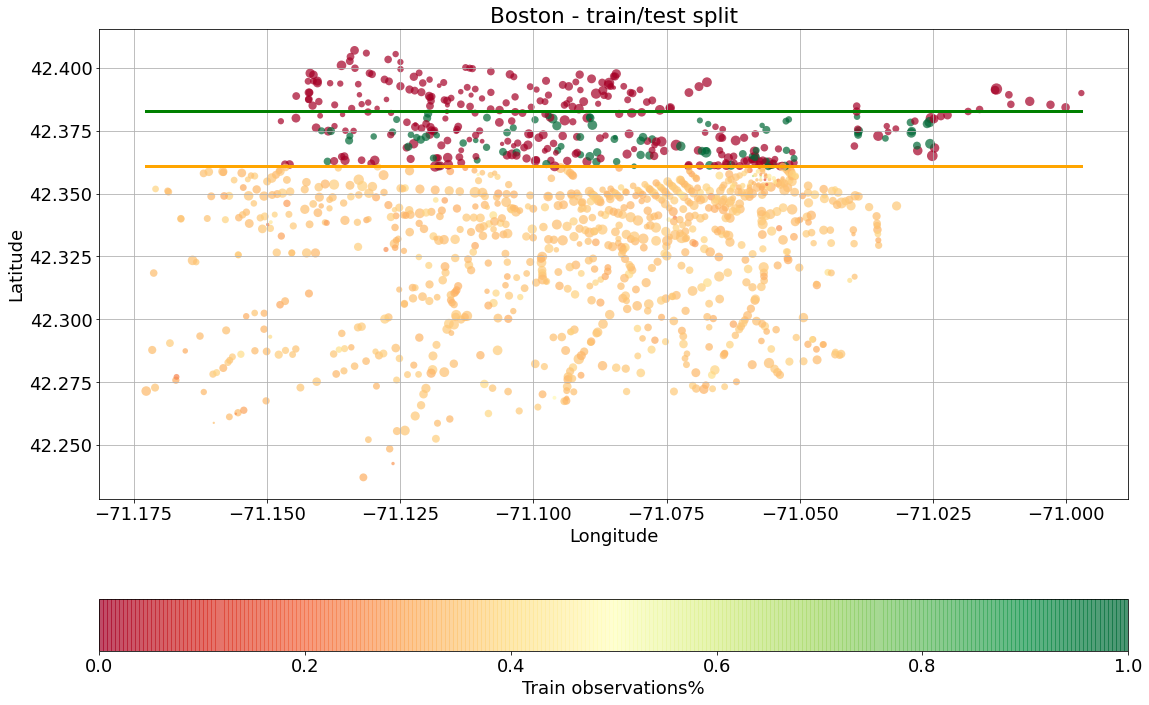

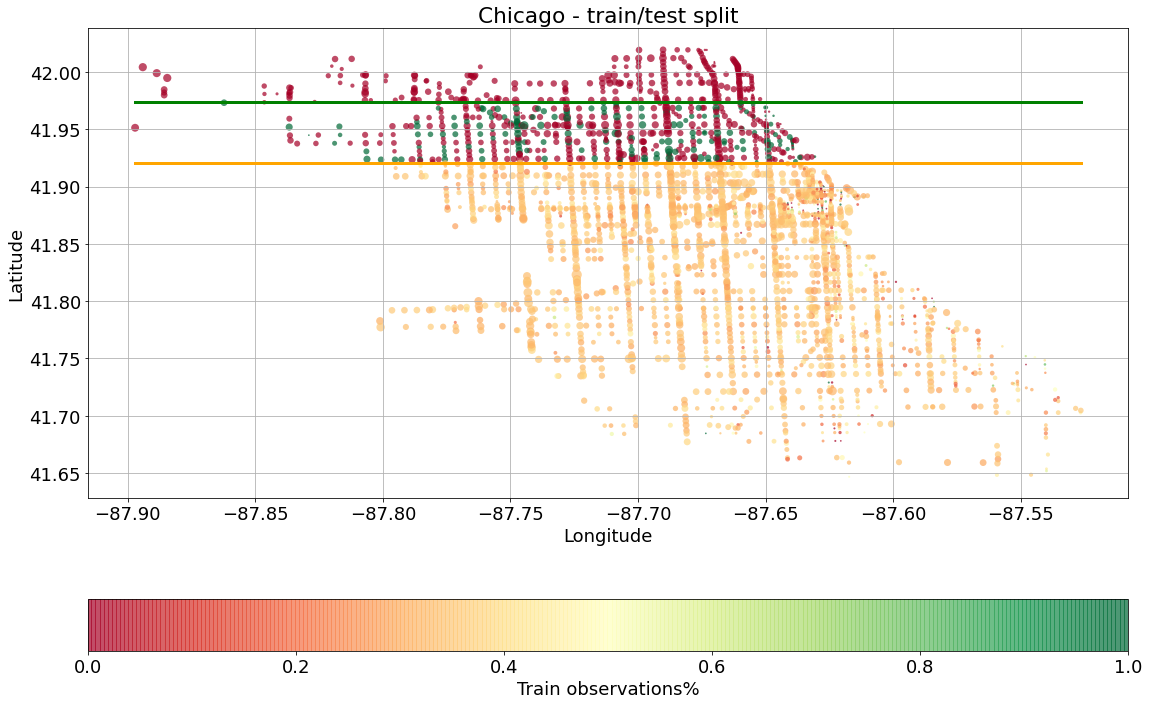

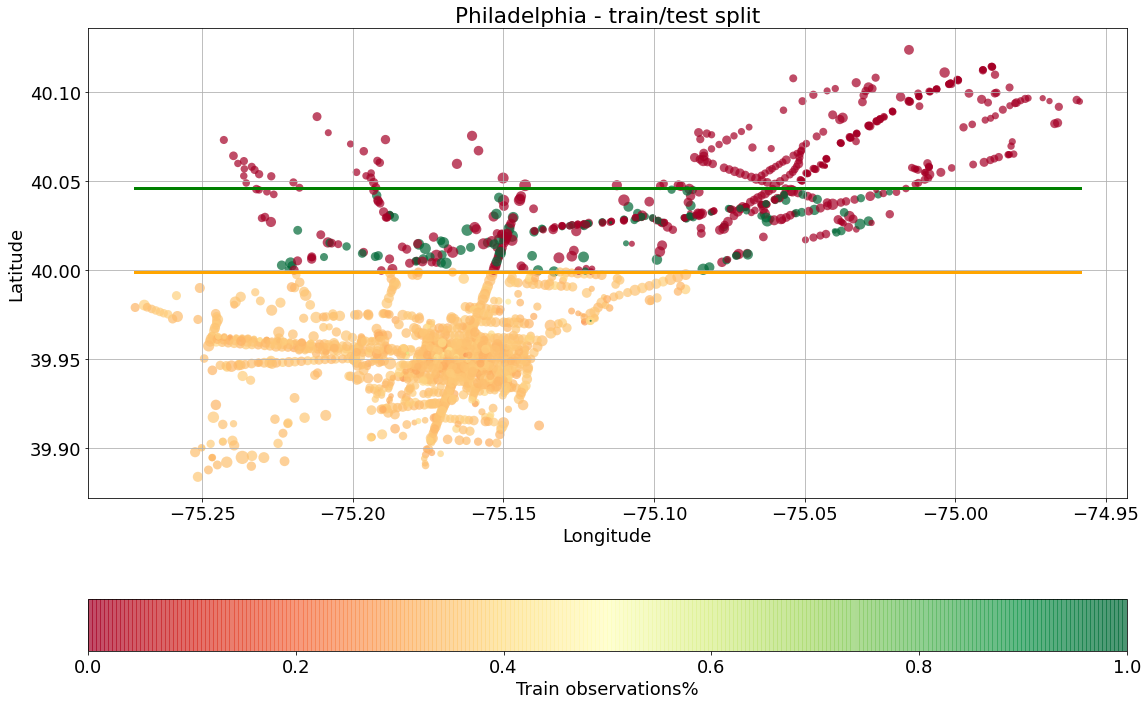

In [20]:
# spacial distribution plot method using matplot
for i, city in enumerate(df.City.unique()):
    coords = df[df.City == city]
    fig, ax = plt.subplots()
    sc = ax.scatter(
        y=coords.Latitude,
        x=coords.Longitude,
        c=coords.IsTrain,
        s = 3 * np.sqrt(coords.Cnt),
        alpha=0.7,
        linewidths=0.,
        cmap=plt.cm.RdYlGn
    )
    l1 = validation_splits[validation_splits.City == city].l1.values[0]
    l2 = validation_splits[validation_splits.City == city].l2.values[0]
    plt.plot([coords.Longitude.min(), coords.Longitude.max()],
             [l1, l1], color='orange', lw = 3)
    plt.plot([coords.Longitude.min(), coords.Longitude.max()],
             [l2, l2], color='green', lw = 3)
    plt.grid()
    cbar = plt.colorbar(sc, orientation='horizontal')
    cbar.set_label('Train observations%')
    plt.tight_layout()
    plt.title(f'{city} - train/test split')
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    
plt.show();

In [22]:
full.groupby(['IsTrain', 'ValidationGroup'])[['RowId']].count()

RowId
IsTrain ValidationGroup         
0       0                1286401
        1                 365456
        2                 269500
1       0                 663510
        1                 192877

## Retraining 
Now that we have a better understanding of our results, we will retrain our model with new hyperparameters to try to reduce the overfitting of the model. We are changing the number of rounds and adjusting a few parameters.

We will also record the importance of each feature in a csv/dataframe for further analysis of deciding which features yield the best results.

In [33]:
# load data
full = pd.read_csv('./data/features_v3.csv.gz')
full.head()

,City,DistanceToFirstStop_p20,DistanceToFirstStop_p40,DistanceToFirstStop_p50,DistanceToFirstStop_p60,DistanceToFirstStop_p80,EntryHeading,EntryStreetName,ExitHeading,ExitStreetName,Hour,IntersectionId,Istrain,Latitude,Longitude,Month,Path,RowId,TimeFromFirstStop_p20,TimeFromFirstStop_p40,TimeFromFirstStop_p50,TimeFromFirstStop_p60,TimeFromFirstStop_p80,TotalTimeStopped_p20,TotalTimeStopped_p40,TotalTimeStopped_p50,TotalTimeStopped_p60,TotalTimeStopped_p80,Weekend,ValidationGroup,Latitude3,Longitude3,EntryStreetMissing,ExitStreetMissing,CMWH,DiffHeading,Rainfall,Temperature,EntryType,ExitType,Intersection,SameStreet,LatitudeDist,LongitudeDist,CenterDistL1,CenterDistL2,Longitude3Count,Latitude3Count,ExitStreetNameCount,EntryStreetNameCount,IntersectionCount,Longitude3UniqueIntersections,Latitude3UniqueIntersections,ExitStreetNameUniqueIntersections
0,0,0.0,0.0,0.0,0.0,0.0,1.75,212,1.75,209,0,0,1,-2.007996,-1.096389,6,Marietta Boulevard Northwest_NW_Marietta Boule...,1921357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,33.792,-84.43,0,0,167,0.0,3.63,76,4,4,0,1,0.026,0.032,0.29,0.124,1560,8260,7890,7750,650,2,10,9
1,0,0.0,0.0,0.0,0.0,0.0,0.75,212,0.75,209,0,0,1,-2.007996,-1.096389,6,Marietta Boulevard Northwest_SE_Marietta Boule...,1921358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,33.792,-84.43,0,0,167,0.0,3.63,76,4,4,0,1,0.026,0.032,0.29,0.124,1560,8260,7890,7750,650,2,10,9
2,0,0.0,0.0,0.0,0.0,0.0,1.75,212,1.75,209,1,0,1,-2.007996,-1.096389,6,Marietta Boulevard Northwest_NW_Marietta Boule...,1921359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,33.792,-84.43,0,0,168,0.0,3.63,76,4,4,0,1,0.026,0.032,0.29,0.124,1560,8260,7890,7750,650,2,10,9
3,0,0.0,0.0,0.0,0.0,0.0,0.75,212,0.75,209,1,0,1,-2.007996,-1.096389,6,Marietta Boulevard Northwest_SE_Marietta Boule...,1921360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,33.792,-84.43,0,0,168,0.0,3.63,76,4,4,0,1,0.026,0.032,0.29,0.124,1560,8260,7890,7750,650,2,10,9
4,0,0.0,0.0,0.0,0.0,0.0,1.75,212,1.75,209,2,0,1,-2.007996,-1.096389,6,Marietta Boulevard Northwest_NW_Marietta Boule...,1921361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,33.792,-84.43,0,0,179,0.0,3.63,76,4,4,0,1,0.026,0.032,0.29,0.124,1560,8260,7890,7750,650,2,10,9


In [36]:
full['random'] = np.random.rand(len(full))

train = full[full.Istrain == 1]
test = full[full.Istrain == 0]

column_stats = pd.concat([
    pd.DataFrame(full.count()).rename(columns={0: 'cnt'}),
    pd.DataFrame(full.nunique()).rename(columns={0: 'unique'}),
], sort=True, axis=1)
column_stats.sort_values(by='unique')

train_columns = list(column_stats[column_stats.cnt < 10 ** 6].index)
print(train_columns)

target_columns = [
    'TotalTimeStopped_p20',
    'TotalTimeStopped_p50',
    'TotalTimeStopped_p80',
    'DistanceToFirstStop_p20',
    'DistanceToFirstStop_p50',
    'DistanceToFirstStop_p80',
]

do_not_use = train_columns + ['IsTrain', 'Path', 'RowId', 'IntersectionId',
                              'random', 'intersection_random', 'ValidationGroup']

feature_columns = [c for c in full.columns if c not in do_not_use]
print(len(feature_columns))
print(feature_columns)

['DistanceToFirstStop_p20', 'DistanceToFirstStop_p40', 'DistanceToFirstStop_p50', 'DistanceToFirstStop_p60', 'DistanceToFirstStop_p80', 'TimeFromFirstStop_p20', 'TimeFromFirstStop_p40', 'TimeFromFirstStop_p50', 'TimeFromFirstStop_p60', 'TimeFromFirstStop_p80', 'TotalTimeStopped_p20', 'TotalTimeStopped_p40', 'TotalTimeStopped_p50', 'TotalTimeStopped_p60', 'TotalTimeStopped_p80']
35
['City', 'EntryHeading', 'EntryStreetName', 'ExitHeading', 'ExitStreetName', 'Hour', 'Istrain', 'Latitude', 'Longitude', 'Month', 'Weekend', 'Latitude3', 'Longitude3', 'EntryStreetMissing', 'ExitStreetMissing', 'CMWH', 'DiffHeading', 'Rainfall', 'Temperature', 'EntryType', 'ExitType', 'Intersection', 'SameStreet', 'LatitudeDist', 'LongitudeDist', 'CenterDistL1', 'CenterDistL2', 'Longitude3Count', 'Latitude3Count', 'ExitStreetNameCount', 'EntryStreetNameCount', 'IntersectionCount', 'Longitude3UniqueIntersections', 'Latitude3UniqueIntersections', 'ExitStreetNameUniqueIntersections']


In [37]:
fix = {
    'lambda': 1., 'nthread': 4, 'booster': 'gbtree',
    'silent': 1, 'eval_metric': 'rmse',
    'objective': 'reg:squarederror'}
config = dict(min_child_weight=10,
              eta=0.05, colsample_bytree=0.6,
              max_depth=20, subsample=0.8)
config.update(fix)
nround = 1000

In [ ]:
# same training loop as the original, but has the feature importance score at the end of the loop
total_mse = 0.0
targets = []
feature_importances = []
for i, target in enumerate(target_columns):
    print(f'Training and predicting for target {target}')
    train_idx = train.random < TRAIN_SAMPLE_SIZE
    valid_idx = train.random >= TRAIN_SAMPLE_SIZE

    Xtr = train[train_idx][feature_columns]
    Xv = train[valid_idx][feature_columns]
    ytr = train[train_idx][target].values
    yv = train[valid_idx][target].values
    print(Xtr.shape, ytr.shape, Xv.shape, yv.shape)

    dtrain = xgb.DMatrix(Xtr, label=ytr)
    dvalid = xgb.DMatrix(Xv, label=yv)

    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    model = xgb.train(config, dtrain, nround, evals=watchlist,
                      verbose_eval=100, early_stopping_rounds=50)

    pv = model.predict(dvalid)
    mse = np.mean((yv - pv) ** 2)
    total_mse += mse / 6
    print(target, 'rmse', np.sqrt(mse))
    
    # Feature Importance
    f = model.get_fscore()
    f = pd.DataFrame({'feature': list(f.keys()), 'imp': list(f.values())})
    f.imp = f.imp / f.imp.sum()
    feature_importances.append(f)
    fimp = pd.concat(feature_importances).groupby(['feature']).sum()
    fimp = fimp.sort_values(by='imp', ascending=False).reset_index()
    fimp.to_csv('fimp_overfitted.csv', index=False)

Training and predicting for target TotalTimeStopped_p20
(642389, 35) (642389,) (213998, 35) (213998,)
[14:10:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:7.15048	valid-rmse:7.04561
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[100]	train-rmse:4.01438	valid-rmse:5.44426
Stopping. Best iteration:
[115]	train-rmse:3.88621	valid-rmse:5.43791

TotalTimeStopped_p20 rmse 5.446002681195206
Training and predicting for target TotalTimeStopped_p50
(642389, 35) (642389,) (213998, 35) (213998,)
[14:22:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent

In [ ]:
#save model
joblib.dump(model, "./models/xgboost_retrained.h5") 

In [ ]:
rmse = np.sqrt(total_mse)
print('Total rmse', rmse)